

#DATASET PREPARATION



In [ ]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
start_date = '1999-11-01'
end_date = '2024-01-01'

In [ ]:
# Fetch Meta data
meta_data = yf.download(
    'META',
    start=start_date,
    end=end_date
)

meta_data.tail()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META,META
Date,,,,,,
2023-12-22 00:00:00+00:00,352.329193,353.390015,357.200012,351.220001,355.579987,11764200
2023-12-26 00:00:00+00:00,353.764862,354.829987,356.980011,353.450012,354.989990,9898600
2023-12-27 00:00:00+00:00,356.755829,357.829987,359.000000,355.309998,356.070007,13207900
2023-12-28 00:00:00+00:00,357.244354,358.320007,361.899994,357.809998,359.700012,11798800
2023-12-29 00:00:00+00:00,352.897461,353.959991,360.000000,351.820007,358.989990,14980500


# Data Preprocessing

In [ ]:
# Checking for missing values
meta_data.isnull().sum()

# Filling missing values, if any
meta_data.fillna(method='ffill', inplace=True)

<ipython-input-18-a1a14b1b75cc>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  meta_data.fillna(method='ffill', inplace=True)


## Feature Selection (Close Price)

## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
meta_data_scaled = scaler.fit_transform(meta_data['Close'].values.reshape(-1,1))

## Sequence Format

In [ ]:
X = []
y = []

for i in range(360, len(meta_data_scaled)):
    X.append(meta_data_scaled[i-360:i, 0])
    y.append(meta_data_scaled[i, 0])

## Train-Test Split

In [ ]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Finally, we need to reshape our data into a 3D format [samples, time steps, features] required by LSTM layers.
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Model Implementation

## Creating LSTM Layers

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply, Input

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))

# Define the input shape (replace 'X_train.shape[1:]' with your actual input shape)
input_tensor = Input(shape=X_train.shape[1:])

# Call the model with the input tensor
model_output = model(input_tensor)

attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

## Model Optimization

In [ ]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

## Model Compilation

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 360, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 360, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute (Permute)                    │ (None, 50, 360)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 360)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute_1 (Permute)                  │ (None, 360, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 360, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          18,001 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1)                   │               4 │
│ (BatchNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,605 (189.86 KB)

 Trainable params: 48,603 (189.86 KB)

 Non-trainable params: 2 (8.00 B)

## Train Model

In [ ]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - loss: 0.9249 - val_loss: 0.4724
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 307ms/step - loss: 0.0865 - val_loss: 0.4052
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - loss: 0.0395 - val_loss: 0.3500
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 343ms/step - loss: 0.0228 - val_loss: 0.2844
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 326ms/step - loss: 0.0151 - val_loss: 0.2023
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - loss: 0.0099 - val_loss: 0.1864
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 311ms/step - loss: 0.0075 - val_loss: 0.1457
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - loss: 0.0060 - val_loss: 0.1043
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - loss: 0.0045 - val_loss: 0.1214
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.0049 - val_loss: 0.0500
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - loss: 0.0049 - val_loss: 0.0369
Epoch 12/100
66/66 ━━━━━━━━━━━

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - loss: 0.0048 - val_loss: 0.0244
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 322ms/step - loss: 0.0042 - val_loss: 0.0077
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 302ms/step - loss: 0.0071 - val_loss: 0.0598
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - loss: 0.0056 - val_loss: 0.0254
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - loss: 0.0035 - val_loss: 0.0166
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 315ms/step - loss: 0.0038 - val_loss: 0.0369
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step - loss: 0.0041 - val_loss: 0.0145
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 316ms/step - loss: 0.0038 - val_loss: 0.0137
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - loss: 0.0038 - val_loss: 0.0071
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 12/100
66/66 ━━━━━━━━━━━

In [ ]:
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# # Callback to save the model periodically
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# # Callback to reduce learning rate when a metric has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# # Callback for TensorBoard
# tensorboard = TensorBoard(log_dir='./logs')

# # Callback to log details to a CSV file
# csv_logger = CSVLogger('training_log.csv')

# # Combining all callbacks
# callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# # Fit the model with the callbacks
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

# Model Evaluation

In [ ]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0107
Test Loss:  0.008490008302032948


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE, RMSE, F1, MSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)

# Printing the metrics
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)
print("Mean Squared Error: ", mse)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Mean Absolute Error:  0.0764650630388364
Root Mean Square Error:  0.0921412380852174
Mean Squared Error:  0.008490007755876718


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


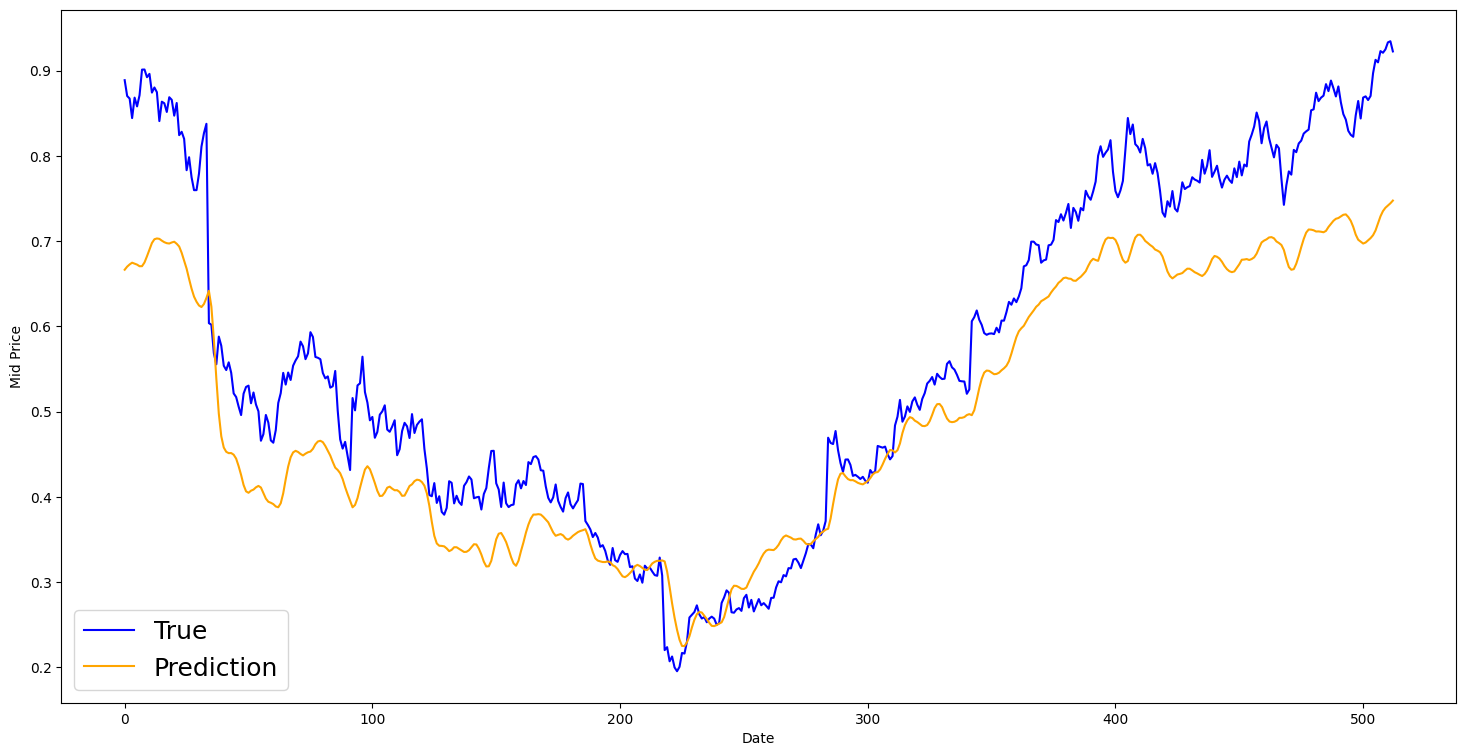

In [ ]:

plt.figure(figsize = (18,9))
plt.plot(range(X_test.shape[0]),y_test,color='b',label='True')
plt.plot(range(X_test.shape[0]),y_pred,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


#Prediction

In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 3 years of META stock data (252 trading days per year)
data = yf.download('META', period='1y', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Ensure the input data size matches the model's expectations
# Prepare the current batch (60 most recent days)
current_batch = scaled_data[-252:].reshape((1, 252, 1))  # Correcting the shape

# Predict for 3 years (about 756 trading days)
predicted_prices = []
days_to_predict = 252  # Approximate trading days in 3 years

for i in range(days_to_predict):
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Ensure the prediction is reshaped correctly before adding it to the batch
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print(f"Predicted Stock Prices for the next {days_to_predict} days (3 years):", predicted_prices)


[*********************100%***********************]  1 of 1 completed


NameError: name 'model' is not defined

#LOAD MODEL AND PREDICT

In [ ]:
import urllib.request
from pathlib import Path
import keras

data_root = "https://github.com/Cullen179/model/raw/main/"
filename = ("lstm-META.keras")

print("Downloading", filename)
url = data_root + filename
urllib.request.urlretrieve(url, "lstm-META-GitHub.keras")


('lstm-META-GitHub.keras', <http.client.HTTPMessage at 0x7fc3c0cfd060>)

In [ ]:
model = keras.models.load_model('lstm-META-GitHub.keras')

In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 3 years of META stock data (252 trading days per year)
data = yf.download('META', period='2y', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Ensure the input data size matches the model's expectations
# Prepare the current batch (60 most recent days)
current_batch = scaled_data[-360:].reshape((1, 360, 1))  # Correcting the shape

# Predict for 3 years (about 756 trading days)
predicted_prices = []
days_to_predict = 252  # Approximate trading days in 3 years

for i in range(days_to_predict):
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Ensure the prediction is reshaped correctly before adding it to the batch
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print(f"Predicted Stock Prices for the next {days_to_predict} days (3 years):", predicted_prices)


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━

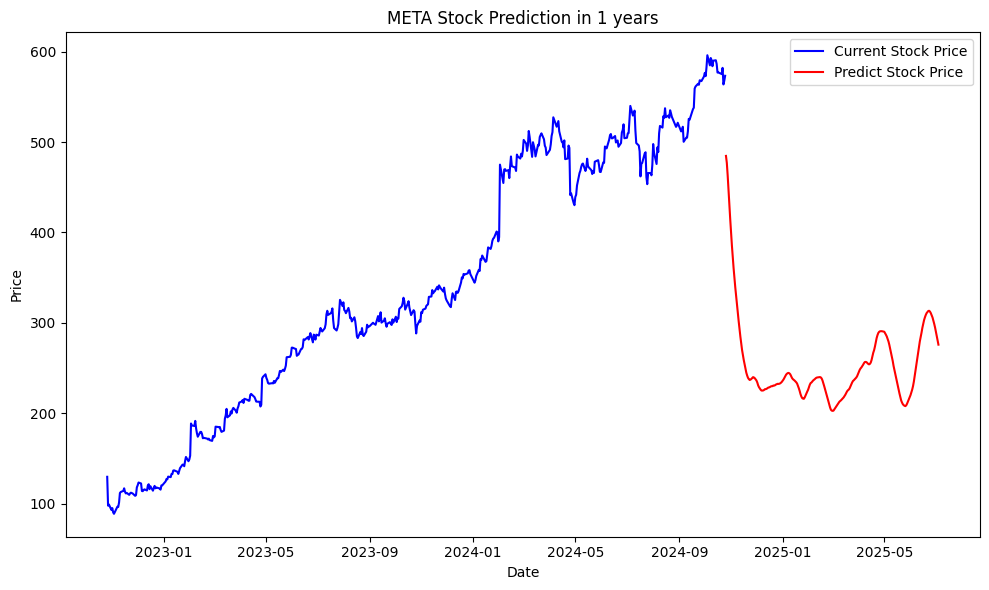

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Flatten multi-level columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]


# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=252)

# Assuming 'predicted_prices' is your list of predicted prices for the next 3 years
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Assuming df1 and df2 are your two DataFrames with prices and index as date
# df1 is the first DataFrame, and df2 is the continuation

# Plot df1
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Close_META'], label='Current Stock Price', color='blue')

# Plot df2 with a different color
plt.plot(predictions_df.index, predictions_df['Close'], label='Predict Stock Price', color='red')

# Adding labels and title
plt.xlabel("Date")
plt.ylabel("Price")

# Add a legend to differentiate between the two DataFrames
plt.legend()
plt.title("META Stock Prediction in 1 years")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Save the entire model
keras.saving.save_model(model, 'lstm-META.keras')

In [ ]:
# Fetch the latest 60 days of AAPL stock data
data = yf.download('META', period='3mo', interval='1d')
model = keras.models.load_model('lstm.keras')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Stock Prices for the next 4 days:  [543.8662, 540.63165, 535.80695, 530.0733]
